In [126]:
import requests
import random
import numpy as np
import pandas as pd
import config
from bs4 import BeautifulSoup
url = "https://www.billboard.com/charts/hot-100/"
response = requests.get(url)
import json
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pprint
from IPython.display import IFrame
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import pickle

In [128]:
# # Retrieve authentification credentials from config.py
client_id = config.client_id
client_secret = config.client_secret

sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(
    client_id=client_id,
    client_secret=client_secret
))
# Perform a search
results = sp.search(q="daddy cool", limit=5, market="GB")

In [130]:
# Billboard Hot 100 URL
BILLBOARD_HOT_100 = "https://www.billboard.com/charts/hot-100/"

# Get top songs and artists from Billboard Hot 100
response = requests.get(BILLBOARD_HOT_100)
soup = BeautifulSoup(response.content, "html.parser")

# Get songs and artists
songs_elements = soup.select(".c-title.a-no-trucate")
artists_elements = soup.select(".c-label.a-no-trucate")

songs = [element.text.strip() for element in songs_elements]
artists = [element.text.strip() for element in artists_elements]

# Create a DataFrame for Billboard Hot 100
billboard_hot_100 = pd.DataFrame({"song_title": songs, "artist": artists})

# Spotify playlist IDs
PLAYLIST_IDS = [
    "37i9dQZF1DX8FwnYE6PRvL", "37i9dQZF1DWVV27DiNWxkR", "37i9dQZF1DWSvKsRPPnv5o",
    "37i9dQZF1DX5hHfOi73rY3", "0cc8YMQWsSzODyTpdVB6mI", "37i9dQZF1DXa71eg5j9dKZ",
    "4kw9kdjzx1UmyWvpysl0y2", "31ymdYCITDnZRtkKzP3Itp", "37i9dQZF1DXcBWIGoYBM5M",
    "6vDGVr652ztNWKZuHvsFvx", "068WHS0zOWsqvn2uIBYb5D", "65xSncKQzG6Suseh5gfYP1",
    "37i9dQZF1DWVzZlRWgqAGH", "37i9dQZF1DXc8kgYqQLMfH", "1xNWydoMmA8210KeHU948w"
]

In [131]:
billboard_hot_100.head(50)


,song_title,artist
0,A Bar Song (Tipsy),Shaboozey
1,Die With A Smile,Lady Gaga & Bruno Mars
2,Birds Of A Feather,Billie Eilish
3,Espresso,Sabrina Carpenter
4,Lose Control,Teddy Swims
5,That's So True,Gracie Abrams
6,I Had Some Help,Post Malone Featuring Morgan Wallen
7,Taste,Sabrina Carpenter
8,Beautiful Things,Benson Boone
9,Love Somebody,Morgan Wallen


In [132]:
# Get audio features from Spotify playlists
audio_features = []
songs_playlists = []

for playlist_id in PLAYLIST_IDS:
    try:
        response = sp.playlist(playlist_id)["tracks"]["items"]
        playlist_track_ids = [item["track"]["id"] for item in response]
        songs_playlists.extend([item["track"]["name"] for item in response])
        audio_features.extend(sp.audio_features(playlist_track_ids))
    except:
        continue
# Create DataFrame with audio features
audio_features_songs = pd.DataFrame({"song_title": songs_playlists, "audio_features": audio_features})
features_df = pd.json_normalize(audio_features_songs["audio_features"])

# Combine the new feature columns with the original DataFrame
audio_features_songs = pd.concat([audio_features_songs.drop(columns=["audio_features"]), features_df], axis=1)



In [135]:
audio_features_songs = pd.DataFrame({"song_title": songs_playlists, "audio_features": audio_features})

# Create separate columns for each feature
features_df = pd.json_normalize(audio_features_songs["audio_features"])

#Combine the new feature columns with the original DataFrame
audio_features_songs = pd.concat([audio_features_songs.drop(columns=["audio_features"]), features_df], axis=1)
audio_features_songs

,song_title,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,In the End,0.556,0.864,3,-5.870,0,0.0584,0.009580,0.00000,0.2090,0.4000,105.143,audio_features,60a0Rd6pjrkxjPbaKzXjfq,spotify:track:60a0Rd6pjrkxjPbaKzXjfq,https://api.spotify.com/v1/tracks/60a0Rd6pjrkx...,https://api.spotify.com/v1/audio-analysis/60a0...,216880,4
1,Pumped Up Kicks,0.733,0.710,5,-5.849,0,0.0292,0.145000,0.11500,0.0956,0.9650,127.975,audio_features,7w87IxuO7BDcJ3YUqCyMTT,spotify:track:7w87IxuO7BDcJ3YUqCyMTT,https://api.spotify.com/v1/tracks/7w87IxuO7BDc...,https://api.spotify.com/v1/audio-analysis/7w87...,239600,4
2,Chop Suey!,0.417,0.934,7,-3.908,0,0.1190,0.000278,0.00150,0.1320,0.2870,127.066,audio_features,2DlHlPMa4M17kufBvI2lEN,spotify:track:2DlHlPMa4M17kufBvI2lEN,https://api.spotify.com/v1/tracks/2DlHlPMa4M17...,https://api.spotify.com/v1/audio-analysis/2DlH...,210240,4
3,Thunderstruck,0.502,0.890,4,-5.175,1,0.0364,0.000147,0.01170,0.2170,0.2590,133.520,audio_features,57bgtoPSgt236HzfBOd8kj,spotify:track:57bgtoPSgt236HzfBOd8kj,https://api.spotify.com/v1/tracks/57bgtoPSgt23...,https://api.spotify.com/v1/audio-analysis/57bg...,292880,4
4,Sex on Fire,0.542,0.905,9,-5.653,1,0.0540,0.001720,0.01040,0.1360,0.3740,153.398,audio_features,0ntQJM78wzOLVeCUAW7Y45,spotify:track:0ntQJM78wzOLVeCUAW7Y45,https://api.spotify.com/v1/tracks/0ntQJM78wzOL...,https://api.spotify.com/v1/audio-analysis/0ntQ...,203347,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1082,Good Intentions,0.699,0.655,0,-4.305,1,0.0271,0.016500,0.00000,0.3450,0.3110,99.997,audio_features,6tYabJF1FngvsDfHoetigZ,spotify:track:6tYabJF1FngvsDfHoetigZ,https://api.spotify.com/v1/tracks/6tYabJF1Fngv...,https://api.spotify.com/v1/audio-analysis/6tYa...,206400,4
1083,CLOUDY STORIES (feat. San Holo),0.480,0.606,6,-7.797,1,0.0305,0.068700,0.24300,0.2740,0.0778,81.498,audio_features,5CM41rtmp3whRZX68O8IR8,spotify:track:5CM41rtmp3whRZX68O8IR8,https://api.spotify.com/v1/tracks/5CM41rtmp3wh...,https://api.spotify.com/v1/audio-analysis/5CM4...,195092,4
1084,Thinkin Bout You,0.723,0.672,5,-8.777,0,0.0437,0.473000,0.83700,0.1700,0.3610,126.001,audio_features,0KJ2AQjp4jdd2Cny30k3Hc,spotify:track:0KJ2AQjp4jdd2Cny30k3Hc,https://api.spotify.com/v1/tracks/0KJ2AQjp4jdd...,https://api.spotify.com/v1/audio-analysis/0KJ2...,197143,4
1085,Poison,0.646,0.858,11,-6.202,0,0.0370,0.001980,0.00282,0.0952,0.5060,126.058,audio_features,7IitkGZHawgZ4AsoCRFneY,spotify:track:7IitkGZHawgZ4AsoCRFneY,https://api.spotify.com/v1/tracks/7IitkGZHawgZ...,https://api.spotify.com/v1/audio-analysis/7Iit...,157069,4


In [136]:
# Drop categorical columns
audio_features_songs_num= audio_features_songs.drop(columns=['song_title', 'type', 'id', 'uri', 'track_href', 'analysis_url', 'duration_ms', 'time_signature'])
audio_features_songs_num

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0.556,0.864,3,-5.870,0,0.0584,0.009580,0.00000,0.2090,0.4000,105.143
1,0.733,0.710,5,-5.849,0,0.0292,0.145000,0.11500,0.0956,0.9650,127.975
2,0.417,0.934,7,-3.908,0,0.1190,0.000278,0.00150,0.1320,0.2870,127.066
3,0.502,0.890,4,-5.175,1,0.0364,0.000147,0.01170,0.2170,0.2590,133.520
4,0.542,0.905,9,-5.653,1,0.0540,0.001720,0.01040,0.1360,0.3740,153.398
...,...,...,...,...,...,...,...,...,...,...,...
1082,0.699,0.655,0,-4.305,1,0.0271,0.016500,0.00000,0.3450,0.3110,99.997
1083,0.480,0.606,6,-7.797,1,0.0305,0.068700,0.24300,0.2740,0.0778,81.498
1084,0.723,0.672,5,-8.777,0,0.0437,0.473000,0.83700,0.1700,0.3610,126.001
1085,0.646,0.858,11,-6.202,0,0.0370,0.001980,0.00282,0.0952,0.5060,126.058


In [137]:
# Apply StandardScaler to the selected columns
scaler = StandardScaler()
audio_features_songs_num_scaled = scaler.fit_transform(audio_features_songs_num)

# Convert back to DataFrame while preserving the column names
audio_features_songs_num_scaled = pd.DataFrame(audio_features_songs_num_scaled, columns=audio_features_songs_num.columns)
audio_features_songs_num_scaled

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,-0.573478,0.808544,-0.612765,0.382249,-1.141475,-0.380199,-0.752225,-0.692303,0.210549,-0.127971,-0.737685
1,0.665298,0.134263,-0.065231,0.387388,-1.141475,-0.667459,-0.283182,-0.358929,-0.593900,2.125223,0.072931
2,-1.546302,1.115035,0.482304,0.862355,-1.141475,0.215963,-0.784444,-0.687955,-0.335682,-0.578609,0.040658
3,-0.951409,0.922383,-0.338998,0.552317,0.876059,-0.596628,-0.784897,-0.658386,0.267300,-0.690272,0.269798
4,-0.671460,0.988060,1.029838,0.435349,0.876059,-0.423485,-0.779449,-0.662155,-0.307306,-0.231657,0.975536
...,...,...,...,...,...,...,...,...,...,...,...
1082,0.427341,-0.106551,-1.434067,0.765208,0.876059,-0.688118,-0.728257,-0.692303,1.175319,-0.482899,-0.920386
1083,-1.105381,-0.321095,0.208537,-0.089293,0.876059,-0.654670,-0.547456,0.012132,0.671652,-1.412889,-1.577166
1084,0.595311,-0.032118,-0.065231,-0.329101,-1.141475,-0.524813,0.852883,1.734086,-0.066114,-0.283501,0.002847
1085,0.056408,0.782273,1.577373,0.301008,-1.141475,-0.590725,-0.778549,-0.684128,-0.596737,0.294752,0.004871


In [138]:
# Check for null values
audio_features_songs_num_scaled.isnull().sum()
audio_features_songs_num_scaled.dropna(inplace=True)

In [139]:
# applying K-Means clustering
kmeans = KMeans(n_clusters=18, random_state=1234)
kmeans.fit(audio_features_songs_num_scaled)

KMeans(n_clusters=18, random_state=1234)

In [140]:
labels = kmeans.labels_ # cluster assignments for the training data

In [141]:
# fitting the KMeans model on scaled data
kmeans = KMeans(n_clusters=15, random_state=42)
kmeans.fit(audio_features_songs_num_scaled)  # Fit the model on scaled data

# cluster predictions
clusters = kmeans.predict(audio_features_songs_num_scaled)

# counting the number of points in each cluster
import pandas as pd
pd.Series(clusters).value_counts().sort_index()

0      76
1      59
2     115
3      75
4      68
5     103
6      56
7      48
8      88
9      79
10     81
11    100
12     57
13     29
14     53
Name: count, dtype: int64

In [142]:
clusters_df = pd.Series(clusters)
clusters_df

0        8
1        5
2        3
3        9
4        9
        ..
1082    12
1083     9
1084    11
1085     5
1086     5
Length: 1087, dtype: int32

Training a K-Means model with 2 clusters! 

Training a K-Means model with 3 clusters! 

Training a K-Means model with 4 clusters! 

Training a K-Means model with 5 clusters! 

Training a K-Means model with 6 clusters! 

Training a K-Means model with 7 clusters! 

Training a K-Means model with 8 clusters! 

Training a K-Means model with 9 clusters! 

Training a K-Means model with 10 clusters! 

Training a K-Means model with 11 clusters! 

Training a K-Means model with 12 clusters! 

Training a K-Means model with 13 clusters! 

Training a K-Means model with 14 clusters! 

Training a K-Means model with 15 clusters! 

Training a K-Means model with 16 clusters! 

Training a K-Means model with 17 clusters! 

Training a K-Means model with 18 clusters! 

Training a K-Means model with 19 clusters! 

Training a K-Means model with 20 clusters! 



Text(0.5, 1.0, 'Elbow Method showing the optimal k')

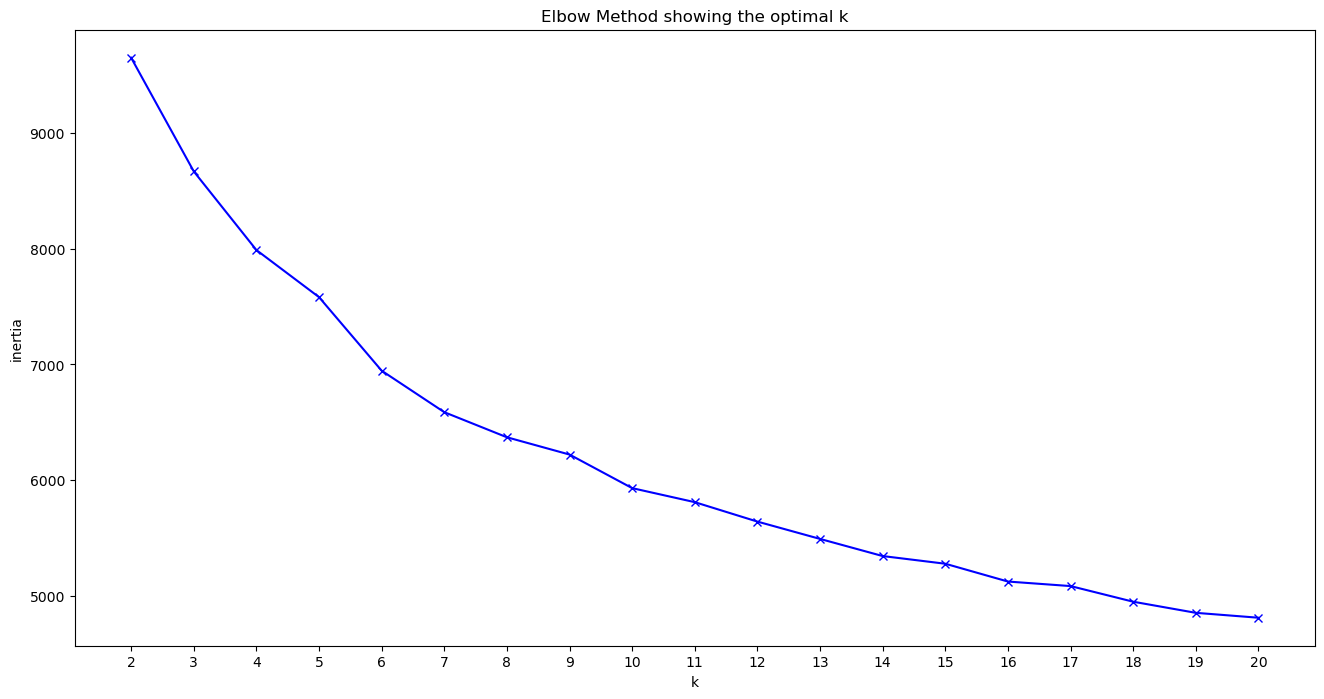

In [143]:
K = range(2, 21) 
inertia = []

for k in K:
    print("Training a K-Means model with {} clusters! ".format(k))
    print()
    kmeans = KMeans(n_clusters=k,
                    random_state=1234)
    kmeans.fit(audio_features_songs_num_scaled)
    inertia.append(kmeans.inertia_)

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Elbow Method showing the optimal k')

Text(0.5, 1.0, 'Silhouette Method showing the optimal k')

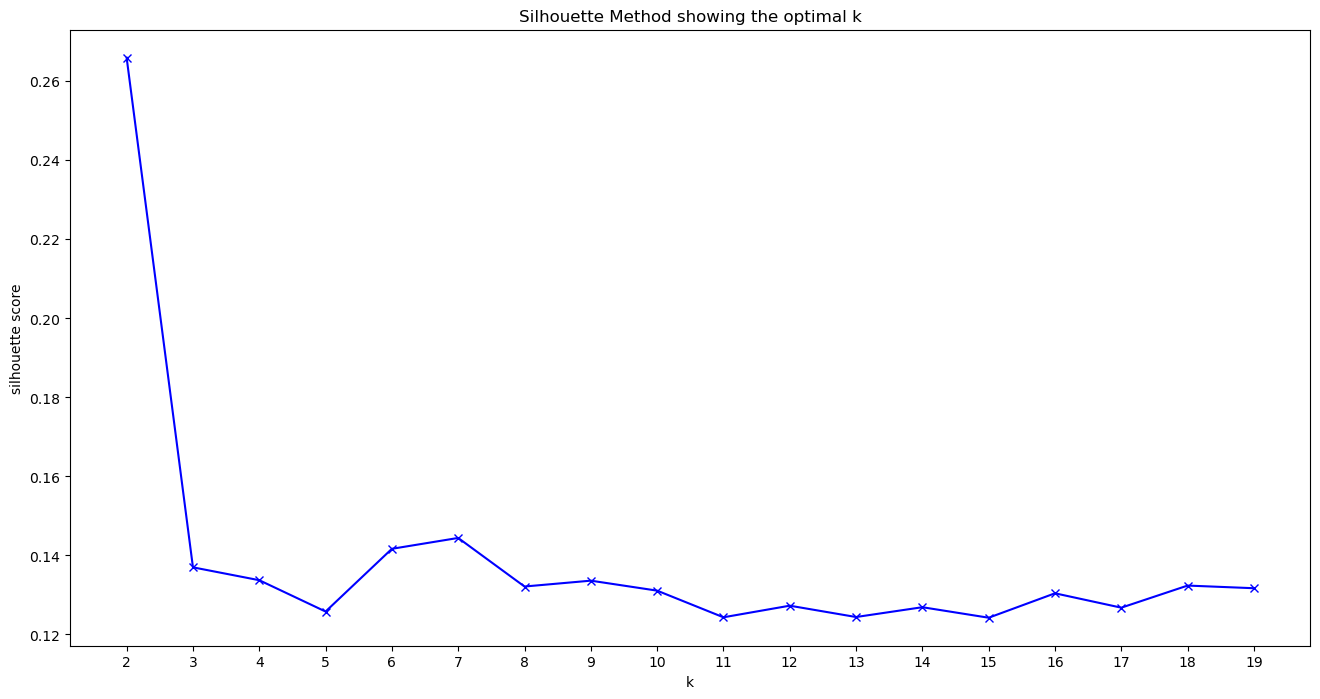

In [144]:
K = range(2, 20)
silhouette = []

for k in K:
    kmeans = KMeans(n_clusters=k,
                    random_state=1234, n_init='auto')
    kmeans.fit(audio_features_songs_num_scaled)
    
    filename = "Model/kmeans_" + str(k) + ".pickle"
    #with open(filename, "wb") as f:
        #pickle.dump(kmeans,f)
    
    silhouette.append(silhouette_score(audio_features_songs_num_scaled, kmeans.predict(audio_features_songs_num_scaled)))


plt.figure(figsize=(16,8))
plt.plot(K, silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Silhouette Method showing the optimal k')

In [145]:
# optimal k=18

In [146]:
audio_features_songs_clusters = pd.concat([audio_features_songs, clusters_df], axis=1)
audio_features_songs_clusters.rename(columns={0: 'KMeans Clusters'}, inplace=True)
audio_features_songs_clusters

,song_title,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,KMeans Clusters
0,In the End,0.556,0.864,3,-5.870,0,0.0584,0.009580,0.00000,0.2090,0.4000,105.143,audio_features,60a0Rd6pjrkxjPbaKzXjfq,spotify:track:60a0Rd6pjrkxjPbaKzXjfq,https://api.spotify.com/v1/tracks/60a0Rd6pjrkx...,https://api.spotify.com/v1/audio-analysis/60a0...,216880,4,8
1,Pumped Up Kicks,0.733,0.710,5,-5.849,0,0.0292,0.145000,0.11500,0.0956,0.9650,127.975,audio_features,7w87IxuO7BDcJ3YUqCyMTT,spotify:track:7w87IxuO7BDcJ3YUqCyMTT,https://api.spotify.com/v1/tracks/7w87IxuO7BDc...,https://api.spotify.com/v1/audio-analysis/7w87...,239600,4,5
2,Chop Suey!,0.417,0.934,7,-3.908,0,0.1190,0.000278,0.00150,0.1320,0.2870,127.066,audio_features,2DlHlPMa4M17kufBvI2lEN,spotify:track:2DlHlPMa4M17kufBvI2lEN,https://api.spotify.com/v1/tracks/2DlHlPMa4M17...,https://api.spotify.com/v1/audio-analysis/2DlH...,210240,4,3
3,Thunderstruck,0.502,0.890,4,-5.175,1,0.0364,0.000147,0.01170,0.2170,0.2590,133.520,audio_features,57bgtoPSgt236HzfBOd8kj,spotify:track:57bgtoPSgt236HzfBOd8kj,https://api.spotify.com/v1/tracks/57bgtoPSgt23...,https://api.spotify.com/v1/audio-analysis/57bg...,292880,4,9
4,Sex on Fire,0.542,0.905,9,-5.653,1,0.0540,0.001720,0.01040,0.1360,0.3740,153.398,audio_features,0ntQJM78wzOLVeCUAW7Y45,spotify:track:0ntQJM78wzOLVeCUAW7Y45,https://api.spotify.com/v1/tracks/0ntQJM78wzOL...,https://api.spotify.com/v1/audio-analysis/0ntQ...,203347,4,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1082,Good Intentions,0.699,0.655,0,-4.305,1,0.0271,0.016500,0.00000,0.3450,0.3110,99.997,audio_features,6tYabJF1FngvsDfHoetigZ,spotify:track:6tYabJF1FngvsDfHoetigZ,https://api.spotify.com/v1/tracks/6tYabJF1Fngv...,https://api.spotify.com/v1/audio-analysis/6tYa...,206400,4,12
1083,CLOUDY STORIES (feat. San Holo),0.480,0.606,6,-7.797,1,0.0305,0.068700,0.24300,0.2740,0.0778,81.498,audio_features,5CM41rtmp3whRZX68O8IR8,spotify:track:5CM41rtmp3whRZX68O8IR8,https://api.spotify.com/v1/tracks/5CM41rtmp3wh...,https://api.spotify.com/v1/audio-analysis/5CM4...,195092,4,9
1084,Thinkin Bout You,0.723,0.672,5,-8.777,0,0.0437,0.473000,0.83700,0.1700,0.3610,126.001,audio_features,0KJ2AQjp4jdd2Cny30k3Hc,spotify:track:0KJ2AQjp4jdd2Cny30k3Hc,https://api.spotify.com/v1/tracks/0KJ2AQjp4jdd...,https://api.spotify.com/v1/audio-analysis/0KJ2...,197143,4,11
1085,Poison,0.646,0.858,11,-6.202,0,0.0370,0.001980,0.00282,0.0952,0.5060,126.058,audio_features,7IitkGZHawgZ4AsoCRFneY,spotify:track:7IitkGZHawgZ4AsoCRFneY,https://api.spotify.com/v1/tracks/7IitkGZHawgZ...,https://api.spotify.com/v1/audio-analysis/7Iit...,157069,4,5


In [147]:
# saving and loading functions for models
def save(model, filename):
    with open(filename, "wb") as f:
        pickle.dump(model, f)

def load(filename):
    try:
        with open(filename, "rb") as f:
            return pickle.load(f)
    except FileNotFoundError:
        print("File not found!")

# Save scaler and KMeans model
save(scaler, "scaler1.pickle")
save(kmeans, "kmeans_final.pkl")
my_best_kmeans = load("kmeans_final.pkl")

In [168]:
# Song recommendation system 

# Check if the song is in the billboard hot 100:
def recommend_song(user_input):
    if user_input in billboard_hot_100["song_title"].values:
        print("Your song is hot!")
        random_song = random.choice(billboard_hot_100["song_title"].values)
        track_id = sp.search(q=random_song, type="track", limit=1)['tracks']['items'][0]["id"]
        print(f"We recommend: {random_song}")
        return track_id
    else:
        print("Sorry, your song is not popular.")
        #  If not in the hot 100 - recommend a song based on musical similarity using clustering:
        try:
            search_result = sp.search(q=user_input, limit=1, type='track')
            if not search_result["tracks"]["items"]:
                print("Could not find the song on Spotify.")
                return None
            print("The song you searched for is :", search_result["tracks"]["items"][0]['name'],
                  "by", search_result["tracks"]["items"][0]['artists'][0]['name'])
            song_id = search_result["tracks"]["items"][0]["id"]
            song_features = sp.audio_features(song_id)[0]
            if not song_features:
                print("Could not retrieve audio features for the song.")
                return None
            similar_songs = audio_features_songs_clusters[audio_features_songs_clusters['KMeans Clusters'] == clusters]
           
            if similar_songs.empty:
                print("No similar songs found in the cluster.")
                return None
            recommended_song = similar_songs.sample(n=1)["song_title"].values[0]
            print(f"We recommend based on musical similarity: {recommended_song}")
            track_id = sp.search(q=recommended_song, type="track", limit=1)['tracks']['items'][0]["id"]  
            return track_id
        except (IndexError, KeyError, spotipy.exceptions.SpotifyException) as e:
            print(f"An error occurred: {e}")

In [170]:
# User input for song recommendation
user_input = input("Enter the name of the song: ")
track_id = recommend_song(user_input)

if track_id:
    # Display embedded player
    iframe = IFrame(src="https://open.spotify.com/embed/track/"+track_id,
           width="320",
           height="80",
           frameborder="0",
           allowtransparency="true",
           allow="encrypted-media",
    )
    display(iframe)

Enter the name of the song:  Espresso


Your song is hot!
We recommend: You Look Like You Love Me
